In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from torch.linalg import norm
from dataset import AdSBHDataset
from model import AdSBHNet
from constants import dreal, dcomplex

coef = 1.7564023430092952


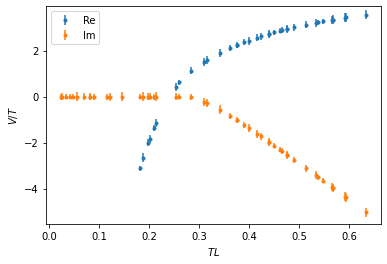

In [2]:
dataset = AdSBHDataset(N=50, threshold=0.0, coef=npr.uniform(0.5, 2))
plt.errorbar(dataset.L.numpy(), dataset.V.real.numpy(), yerr=dataset.sigma.real.numpy(), label='Re', fmt='.')
plt.errorbar(dataset.L.numpy(), dataset.V.imag.numpy(), yerr=dataset.sigma.imag.numpy(), label='Im', fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend()
print(f'coef = {dataset.coef}')

## Consistency check
Learnable parameters set to zero (standard BH).

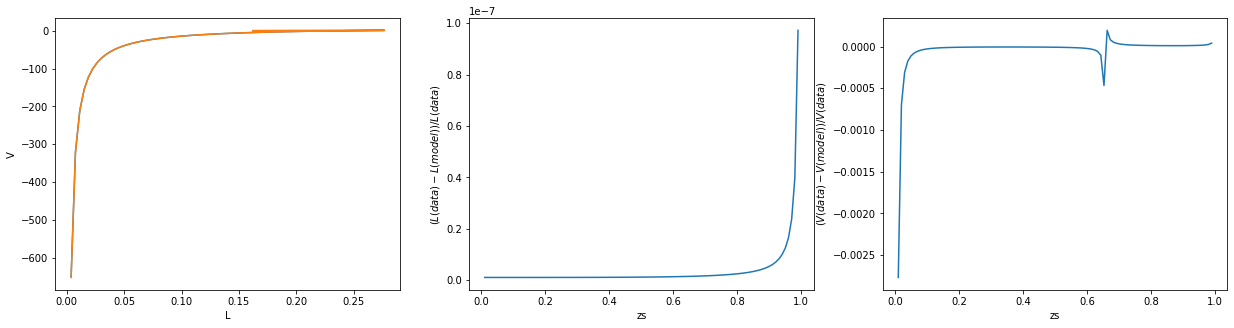

In [3]:
model = AdSBHNet(N=1)
model.a = nn.Parameter(torch.tensor([0.0], dtype=dreal))
model.b = nn.Parameter(torch.tensor([0.0], dtype=dreal))
model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
zs = np.linspace(0.01, 0.99, 100)
d_L = np.array([dataset.integrate_L(z).real for z in zs])
d_V = np.array([dataset.integrate_V(z).real for z in zs])
m_L = np.array([model.integrate_L(z).real.item() for z in zs])
m_V = np.array([model.integrate_V(z).real.item() for z in zs])
fig, axs = plt.subplots(1, 3, figsize=(21, 5))
axs[0].plot(d_L, d_V)
axs[0].plot(m_L, m_V)
axs[0].set_xlabel('L')
axs[0].set_ylabel('V')
axs[1].plot(zs, (d_L-m_L)/d_L)
axs[1].set_xlabel('zs')
axs[1].set_ylabel(r'$(L(data)-L(model))/L(data)$')
axs[2].plot(zs, (d_V-m_V)/d_V)
axs[2].set_xlabel('zs')
axs[2].set_ylabel(r'$(V(data)-V(model))/V(data)$');

Agreement between dataset and model is reasonable with zero parameters. How about with some random parameters?

In [4]:
zsTest = [complex(1.142113675528766,1.3012588340796074), complex(0.0558177255520369,1.5070951885336492), complex(1.9952882318145342,0.6687418969501766), complex(0.4029404311985676,0.40642498555061213), complex(0.11935057057002396,1.7367357212681331), complex(0.99439195050115,1.0048935095851146), complex(1.429581746306488,1.698518466268971), complex(0.8901717500957749,1.0848194713430845), complex(1.4583775699101205,0.5831442903354755), complex(0.41021745342009863,0.24043993263958674)]
model = AdSBHNet(N=2)
model.a = nn.Parameter(torch.tensor([0.11287310832568255, -0.013777758591872451], dtype=dreal))
model.b = nn.Parameter(torch.tensor([0.2185139196679841, -0.06209747957865339], dtype=dreal))
model.logcoef = nn.Parameter(torch.tensor(1.0, dtype=dreal).log())
for zs in zsTest:
    print(f'{zs:.6f}\t{model.integrate_L(zs):.6f}\t{model.integrate_dL(zs):.6f}\t{model.integrate_V(zs):.6f}')

1.142114+1.301259j	0.952336+0.901249j	1.627830-0.643938j	11.724681-5.744751j
0.055818+1.507095j	-0.567585+0.781088j	0.923366+0.605705j	11.702933+9.517656j
1.995288+0.668742j	1.119860-0.111660j	0.234108-0.282592j	1.370656-7.587119j
0.402940+0.406425j	0.160025+0.168966j	0.460877+0.011348j	2.128554+4.736630j
0.119351+1.736736j	-0.665599+1.018376j	0.768210+0.724721j	13.887635+10.398069j
0.994392+1.004894j	0.633669+0.571048j	1.080125-0.260478j	8.247300-2.287960j
1.429582+1.698518j	2.322905+1.166944j	1.830424-4.438994j	14.194953-19.847447j
0.890172+1.084819j	0.530584+0.680790j	1.178036-0.103143j	9.490399-1.177057j
1.458378+0.583144j	0.850353+0.042089j	0.632411-0.383969j	2.755694-4.895604j
0.410217+0.240440j	0.162598+0.096018j	0.419014-0.013268j	-0.508548+4.021609j


Let's check that $a=b=0$ is a local minimum of the loss function

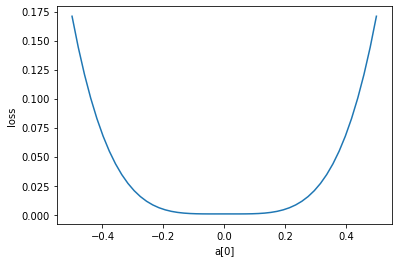

In [5]:
A = np.linspace(-0.5, 0.5, 50)
losses = []
model = AdSBHNet(N=1)
for aval in A:
    model.a = nn.Parameter(torch.tensor([aval], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
    loss = (model(dataset.L) - dataset.V).abs().pow(2).mean()
    losses.append(loss.item())
plt.plot(A, losses)
plt.xlabel('a[0]')
plt.ylabel('loss');

Check that gradients agree with these results.

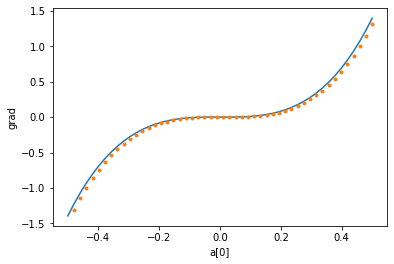

In [6]:
grads = []
model = AdSBHNet(N=1)
for aval in A:
    model.a = nn.Parameter(torch.tensor([aval], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
    model.zero_grad()
    loss = (model(dataset.L) - dataset.V).abs().pow(2).mean()
    loss.backward()
    grads.append(model.a.grad[0].item())
plt.plot(A, grads)
plt.plot(A[1:], (np.array(losses[1:])-np.array(losses[:-1]))/(A[1]-A[0]), '.')
plt.xlabel('a[0]')
plt.ylabel('grad');

Do the same check w.r.t. $b$.

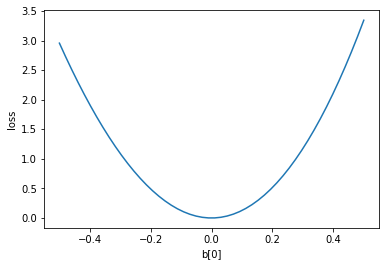

In [7]:
B = np.linspace(-0.5, 0.5, 50)
losses = []
model = AdSBHNet(N=1)
for bval in B:
    model.a = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([bval], dtype=dreal))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
    loss = (model(dataset.L) - dataset.V).abs().pow(2).mean()
    losses.append(loss.item())
plt.plot(B, losses)
plt.xlabel('b[0]')
plt.ylabel('loss');

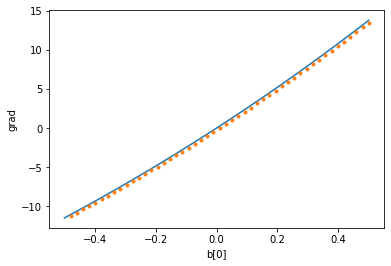

In [8]:
grads = []
model = AdSBHNet(N=1)
for bval in B:
    model.a = nn.Parameter(torch.tensor([0.0], dtype=dreal))
    model.b = nn.Parameter(torch.tensor([bval], dtype=dreal))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dreal).log())
    model.zero_grad()
    loss = (model(dataset.L) - dataset.V).abs().pow(2).mean()
    loss.backward()
    grads.append(model.b.grad[0].item())
plt.plot(B, grads)
plt.plot(B[1:], (np.array(losses[1:])-np.array(losses[:-1]))/(B[1]-B[0]), '.')
plt.xlabel('b[0]')
plt.ylabel('grad');

## Training

In [20]:
model = AdSBHNet(N=2, std=0.5)
#print(list(model.parameters()))
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
epochs = 100
a_vals, b_vals, coef_vals = [model.a.detach().numpy().copy()], [model.b.detach().numpy().copy()], [model.logcoef.exp().item()]
eps = 0.01

z = np.linspace(0, 0.95, 50)
fzInit = model.eval_f(z).detach().numpy()
gzInit = model.eval_g(z).detach().numpy()
fz0 = 1-z**4
gz0 = 1/fz0

try:
    for epoch in range(epochs):
        for L, V, sigma in loader:
            optimizer.zero_grad()
            V_pred = model(L)
            V_diff = V_pred - V
            loss = torch.mean(V_diff.real**2 / sigma.real) + torch.mean(V_diff.imag**2 / sigma.imag)
            loss.backward()
            a_vals.append(model.a.detach().numpy().copy())
            b_vals.append(model.b.detach().numpy().copy())
            coef_vals.append(model.logcoef.exp().item())
            optimizer.step()
        print(f'epoch={epoch:2d}, loss={loss.item():0.6f}')
except KeyboardInterrupt:
    print('Stopping.')

fz = model.eval_f(z).detach().numpy()
gz = model.eval_g(z).detach().numpy()

epoch= 0, loss=402.449001
epoch= 1, loss=58.456212
epoch= 2, loss=27.865108
epoch= 3, loss=71.565622
epoch= 4, loss=6.972416
epoch= 5, loss=14.599746
epoch= 6, loss=14.532453
epoch= 7, loss=1.140905
epoch= 8, loss=3.050796
epoch= 9, loss=2.617454
epoch=10, loss=0.626729
epoch=11, loss=1.502191
epoch=12, loss=0.728677
epoch=13, loss=0.520628
epoch=14, loss=0.737080
epoch=15, loss=0.621041
epoch=16, loss=0.625334
epoch=17, loss=0.432021
epoch=18, loss=0.345526
epoch=19, loss=0.299961
epoch=20, loss=0.287231
epoch=21, loss=0.278589
epoch=22, loss=0.263128
epoch=23, loss=0.255863
epoch=24, loss=0.244283
epoch=25, loss=0.229127
epoch=26, loss=0.208764
epoch=27, loss=0.190236
epoch=28, loss=0.173968
epoch=29, loss=0.159982
epoch=30, loss=0.147319
epoch=31, loss=0.136188
epoch=32, loss=0.126078
epoch=33, loss=0.116723
epoch=34, loss=0.108003
epoch=35, loss=0.099957
epoch=36, loss=0.092555
epoch=37, loss=0.085856
epoch=38, loss=0.079862
epoch=39, loss=0.074474
epoch=40, loss=0.069587
epoch=41,

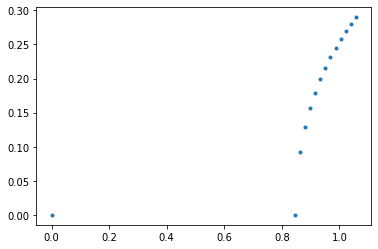

In [21]:
plt.plot([np.real(x) for x in model.curve_zs], [np.imag(x) for x in model.curve_zs], '.')

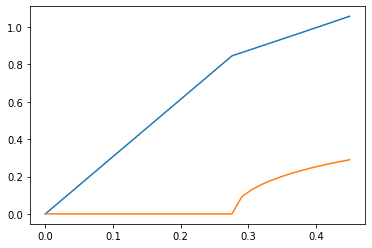

In [22]:
plt.plot(model.curve_L, [np.real(x) for x in model.curve_zs])
plt.plot(model.curve_L, [np.imag(x) for x in model.curve_zs])

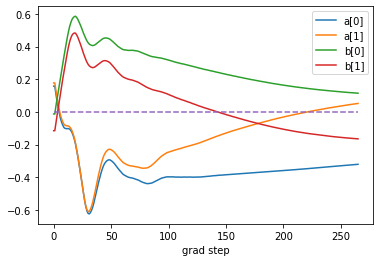

In [24]:
for i in range(len(a_vals[0])):
    plt.plot([a[i] for a in a_vals], label=f'a[{i}]')
for i in range(len(a_vals[0])):
    plt.plot([b[i] for b in b_vals], label=f'b[{i}]')
plt.plot([0]*len(a_vals), '--')
plt.xlabel('grad step')
plt.legend();

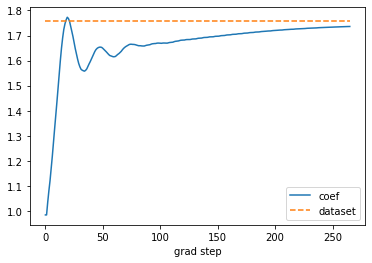

In [25]:
plt.plot(coef_vals, label='coef')
plt.plot([dataset.coef]*len(coef_vals), '--', label='dataset')
plt.xlabel('grad step')
plt.legend();

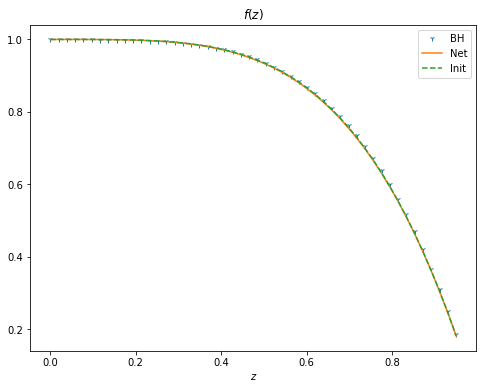

In [26]:
plt.subplots(figsize=(8, 6))
plt.plot(z, fz0, '1', label='BH')
plt.plot(z, fz, label='Net')
plt.plot(z, fzInit, '--', label='Init')
plt.title(f'$f(z)$')
plt.xlabel(f'$z$')
plt.legend();

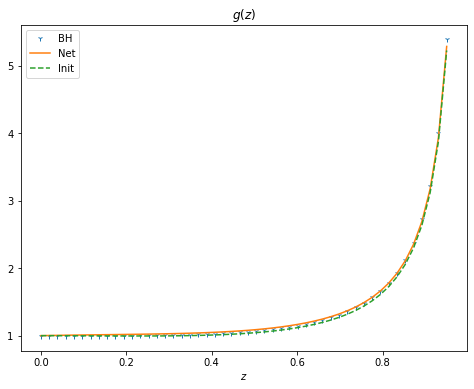

In [27]:
plt.subplots(figsize=(8, 6))
plt.plot(z, gz0, '1', label='BH')
plt.plot(z, gz, label='Net')
plt.plot(z, gzInit, '--', label='Init')
plt.title(f'$g(z)$')
plt.xlabel(f'$z$')
plt.legend();

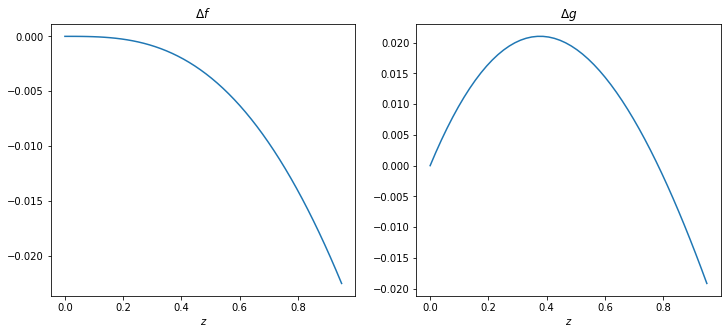

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(z, (fz-fz0)/fz0)
axs[0].set_title(f'$\Delta f$')
axs[0].set_xlabel(f'$z$')
axs[1].plot(z, (gz-gz0)/gz0)
axs[1].set_title(f'$\Delta g$')
axs[1].set_xlabel(f'$z$');